# Photon correlation spectroscopy development
### M. L. Whittaker 
### 26 June 2025

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import skew, kurtosis
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer

import pct

In [44]:
path1 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/CMI/Data/PCT/JM_F0/25C'

In [45]:
data = pd.read_csv(path1 + '/JM_F0_25C_MAPCS_v2.csv', skiprows=3)

In [46]:
data.columns

Index(['Identifier', 'Name', 'Description', 'Mean hydrodynamic radius [nm]',
       'Scaled count rate [kHz/mW]', 'Temperature set point [°C]',
       'Sample name', 'Mass concentration [g/ml]', 'Correlation type',
       'Material', 'Refractive index increment', 'Solvent', 'Duration [s]',
       'Scattering angle [deg]', 'Number of repetitions'],
      dtype='object')

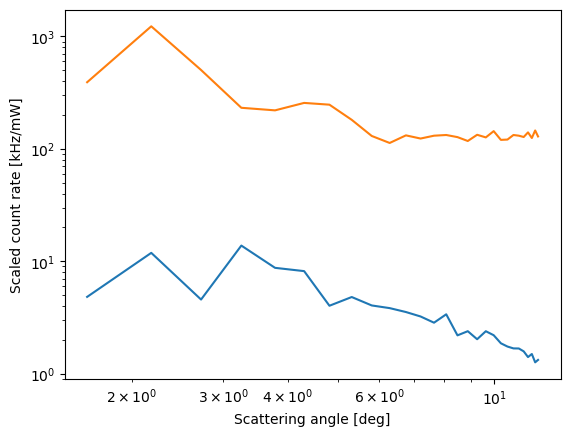

In [47]:
subset1 = data[0::3].sort_values('Scattering angle [deg]')
subset2 = data[1::3].sort_values('Scattering angle [deg]')
plt.plot(4 * np.pi * np.sin(np.deg2rad(subset1['Scattering angle [deg]'])/2), subset1['Scaled count rate [kHz/mW]'])
plt.plot(4 * np.pi * np.sin(np.deg2rad(subset2['Scattering angle [deg]'])/2), subset2['Scaled count rate [kHz/mW]'])
plt.xlabel('Scattering angle [deg]')
plt.xscale('log')
plt.ylabel('Scaled count rate [kHz/mW]')
plt.yscale('log')
plt.show()

In [56]:
path2 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/CMI/Data/PCT/JM_F0/25C/Measurement 1/Repetition 0/Count Trace.csv'

In [57]:
data = pd.read_csv(path2, skiprows=2)

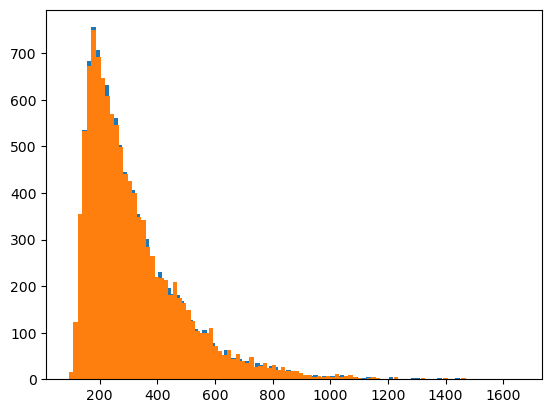

In [58]:
plt.hist(data['CR CHA [kHz]'], bins=100)
plt.hist(data['CR CHB [kHz]'], bins=100); plt.show()

In [62]:
print(skew(data['CR CHB [kHz]']))
print(kurtosis(data['CR CHB [kHz]']))

1.8304781562141024
5.0335635958901275


In [63]:
data = data[['CR CHA [kHz]', 'CR CHB [kHz]']].values

In [64]:
power = PowerTransformer(method='yeo-johnson', standardize=False)
tdata = power.fit_transform(data)

In [65]:
power.lambdas_

array([-0.4224083 , -0.40389986])

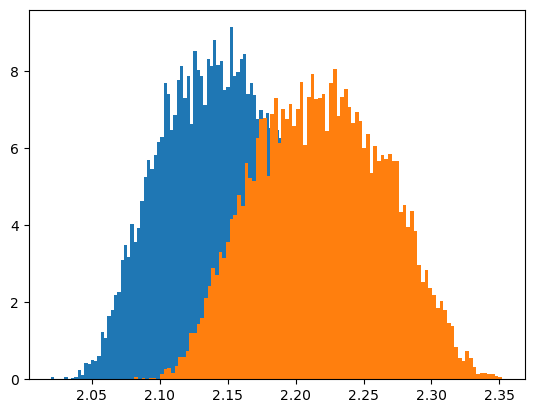

In [210]:
plt.hist(tdata[:,0], bins=100, density=True)
plt.hist(tdata[:,1], bins=100, density=True); plt.show()

In [229]:
for i in range(3):
    gmm = GaussianMixture(random_state=42, n_components=i+1)
    gmm_data = gmm.fit(tdata[:,0].reshape(-1,1))
    print(f'bic_{i+1}: {gmm_data.bic(tdata[:,0].reshape(-1,1))}')
    print(f'aic_{i+1}: {gmm_data.aic(tdata[:,0].reshape(-1,1))}')

bic_1: -39910.40749749967
aic_1: -39925.09636571258
bic_2: -40254.44140484539
aic_2: -40291.16357537767
bic_3: -40250.6041684578
aic_3: -40309.35964130946


In [222]:
print(gmm_data.means_)
print(gmm_data.covariances_)

[[2.14615059]
 [2.19229472]
 [2.0999105 ]]
[[[0.00038892]]

 [[0.00049552]]

 [[0.00046647]]]


In [226]:
power.inverse_transform(gmm_data.means_)

ValueError: X has 1 features, but PowerTransformer is expecting 2 features as input.

In [175]:
gmm_data.covariances_

array([[[0.00038892]],

       [[0.00049552]],

       [[0.00046647]]])

In [218]:
gmm_data.means_ + np.sqrt(gmm_data.covariances_[:,0].reshape(-1,1))

array([[2.18715984]])

In [216]:
power.inverse_transform(gmm_data.means_ + np.sqrt(gmm_data.covariances_[:,0].reshape(-1,1)))

ValueError: X has 1 features, but PowerTransformer is expecting 2 features as input.

In [3]:
pct1 = pct.Dataloader(path1)
data = pct1.load()

In [35]:
cf = data.experiments['Measurement 1']['measurements'][0]['repetitions']['Correlation Function.csv']

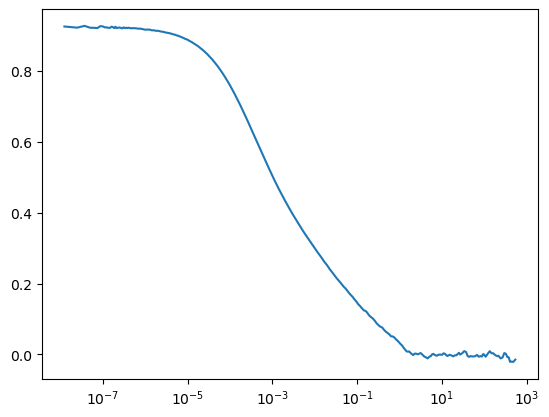

In [36]:
plt.plot(cf['Lag time [s]'], cf['Value'])
plt.xscale('log')

In [37]:
tt = data.experiments['Measurement 1']['measurements'][0]['repetitions']['Count Trace.csv']

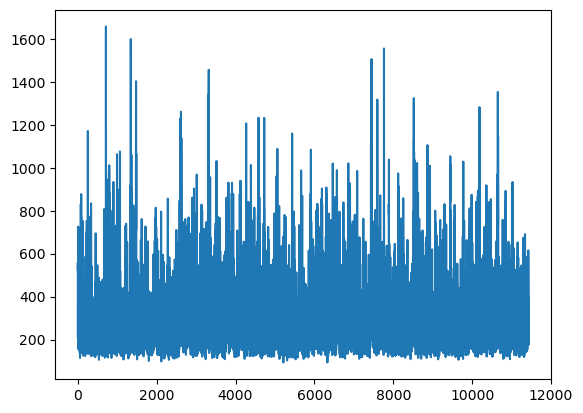

In [38]:
plt.plot(tt['CR CHB [kHz]'])

In [41]:
I_A = np.array(tt['CR CHA [kHz]'])
I_B = np.array(tt['CR CHA [kHz]'])

# Normalize by the average intensities
mean_I_A = np.mean(I_A)
mean_I_B = np.mean(I_B)

# Outer product of intensity traces
two_time_corr = np.outer(I_A, I_B) / (mean_I_A * mean_I_B)

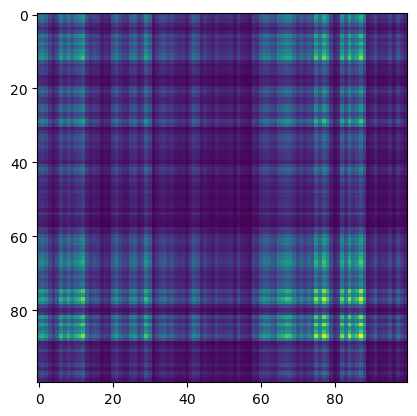

In [42]:
plt.imshow(two_time_corr[:100, :100])

In [33]:
tt['Time [s]']

0          0.000000
1          0.052470
2          0.104941
3          0.157411
4          0.209882
            ...    
11430    599.737648
11431    599.790118
11432    599.842589
11433    599.895059
11434    599.947530
Name: Time [s], Length: 11435, dtype: float64

In [34]:
test_corr1 = correlate(I_A,I_A,mode='same')